# Bayesian Reasoning and Machine Learning

### Michel Mariën, Assignment 1

## Notebook setup

#### Installing required packages

In [146]:
!pip install pyagrum
#!pip install graphviz
#!pip install pydot

#### Importing required packages

In [147]:
import numpy as np
import pandas as pd
import math
import graphviz
from google.colab import drive
import matplotlib.pyplot as plt
import pydot
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pyagrum.causal as csl
import pyagrum.causal.notebook as cslnb
import pyagrum as gum
import pyagrum.lib.notebook as gnb

### Data preprocessing

#### Upload data

In [148]:
drive.mount("/content/drive")

file_path = '/content/drive/My Drive/Master_AI/BRML/ai4i2020.csv'
df_raw = pd.read_csv(file_path)
df_raw.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OS

In [149]:
# Renaming columns
df_data = df_raw.rename(columns={'UDI': 'uid',
                                'Product ID': 'product_id',
                                'Type': 'prod_quality',
                                'Air temperature [K]': 'air_temp',
                                'Process temperature [K]': 'process_temp',
                                'Rotational speed [rpm]': 'rot_speed',
                                'Torque [Nm]': 'torque',
                                'Tool wear [min]': 'tool_wear',
                                'Machine failure': 'machine_failure',
                                'TWF': 'tool_wear_failure',
                                'HDF': 'heat_dissipation_failure',
                                'PWF': 'power_failure',
                                'OSF': 'overstrain_failure',
                                'RNF': 'random_failure'})

In [150]:
# Drop columns
df_data.drop(['uid', 'product_id'],axis=1,inplace=True)

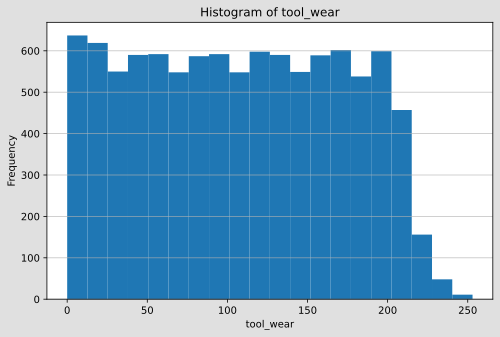

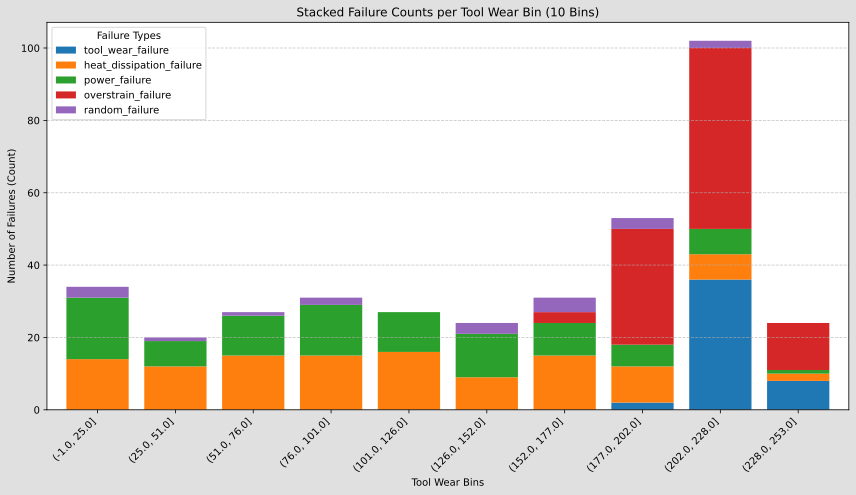

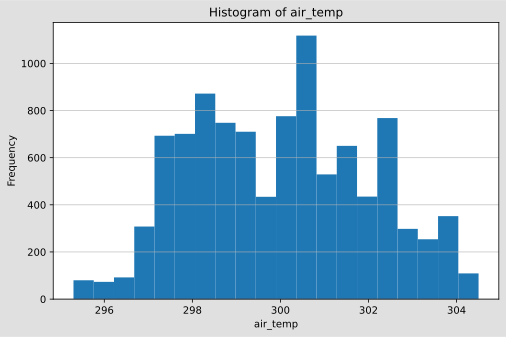

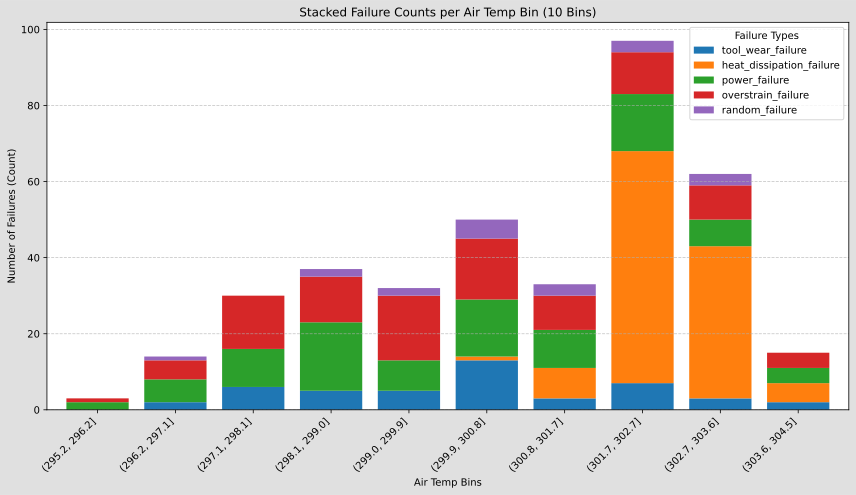

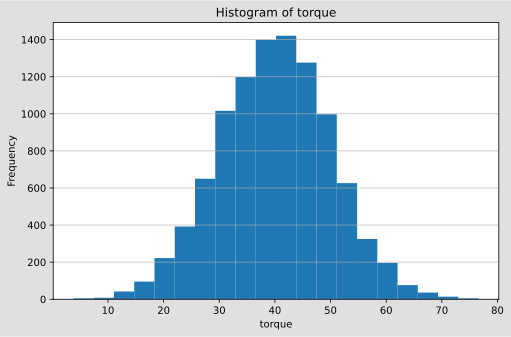

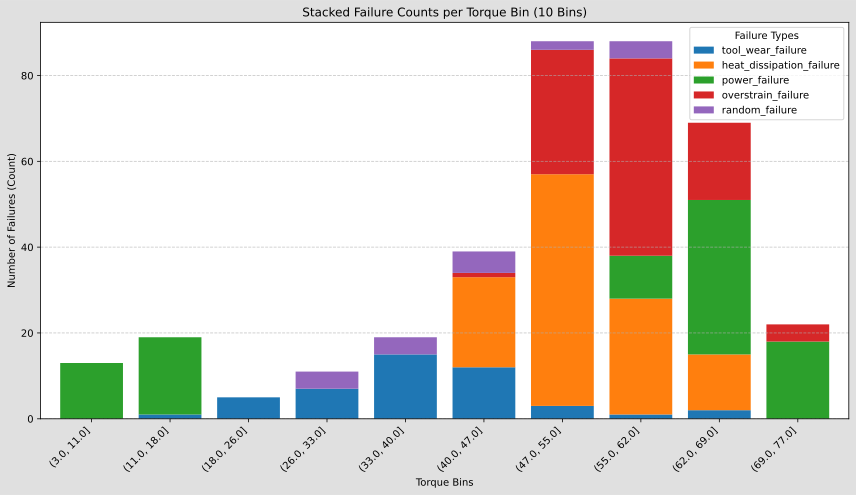

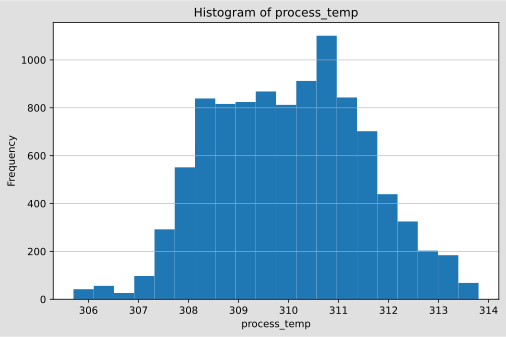

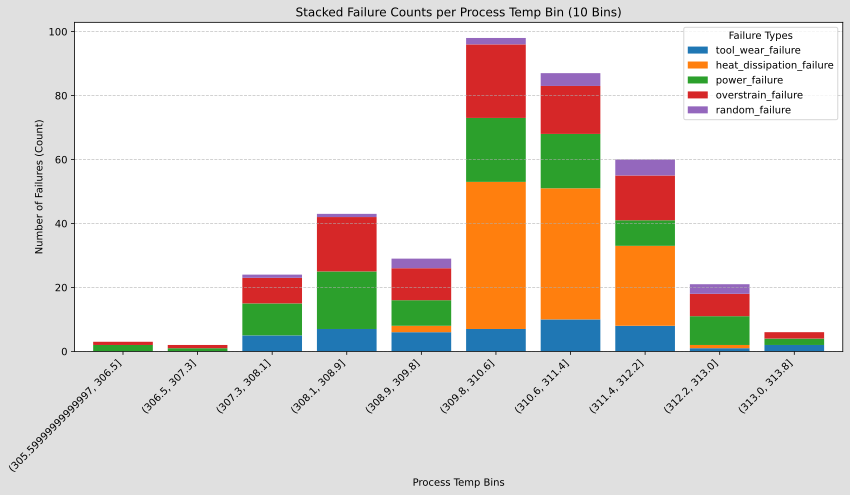

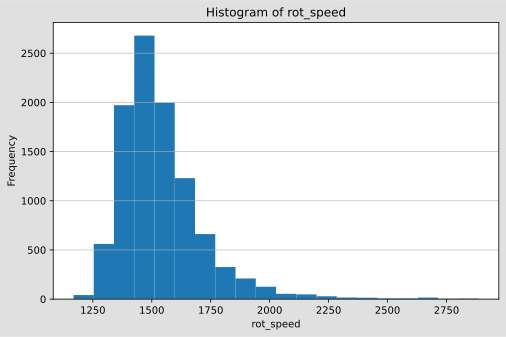

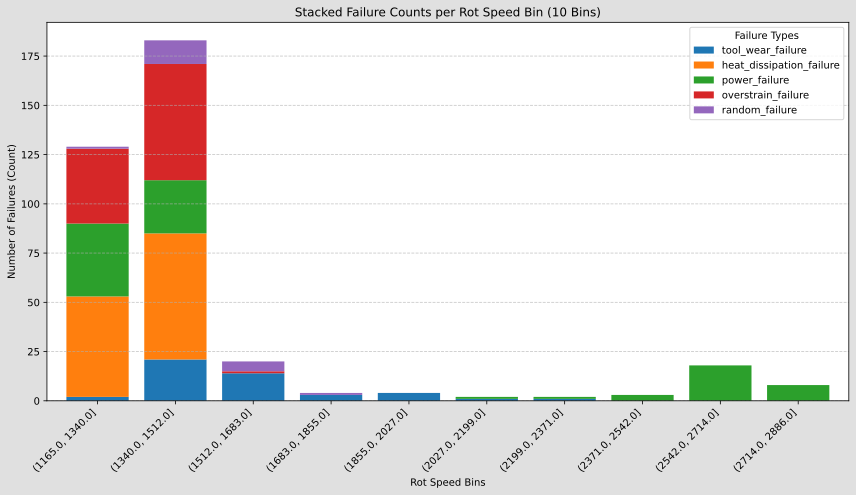

In [151]:
# Visualize numeric columns
numeric_cols = ['tool_wear', 'air_temp', 'torque', 'process_temp', 'rot_speed']
failure_cols_for_plotting = ['tool_wear_failure', 'heat_dissipation_failure','power_failure', 'overstrain_failure', 'random_failure']
NUM_BINS_FOR_STACKED_CHART = 10

df_to_plot = df_data

for num_col in numeric_cols:

    numeric_series = pd.to_numeric(df_to_plot[num_col], errors='coerce')

    # Histogram of the values
    plt.figure(figsize=(8, 5))
    numeric_series.plot(kind='hist', bins=20, title=f'Histogram of {num_col}')
    plt.xlabel(num_col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Stacked bar chart with failures per variable
    temp_binned_col_name = f"{num_col}_binned_for_stacked_plot"
    df_temp_plotting = df_to_plot.copy()

    for fc in failure_cols_for_plotting:
        if fc in df_temp_plotting.columns:
            if df_temp_plotting[fc].dtype == 'bool':
                df_temp_plotting[fc] = df_temp_plotting[fc].astype(int)
            elif not pd.api.types.is_numeric_dtype(df_temp_plotting[fc]):
                 df_temp_plotting[fc] = pd.to_numeric(df_temp_plotting[fc], errors='coerce').fillna(0).astype(int)

    df_temp_plotting[temp_binned_col_name] = pd.cut(
        numeric_series,
        bins= 10,
        precision=0,
        include_lowest=True,
        duplicates='drop')

    try:
        failure_counts_per_bin = df_temp_plotting.groupby(temp_binned_col_name, observed=False)[valid_failure_cols_in_temp_df].sum()
    except Exception:
        continue

    if not failure_counts_per_bin.empty and failure_counts_per_bin.sum().sum() > 0 :
        failure_counts_per_bin.plot(kind='bar', stacked=True, figsize=(12, 7), width=0.8)
        plt.title(f'Stacked Failure Counts per {num_col.replace("_", " ").title()} Bin ({NUM_BINS_FOR_STACKED_CHART} Bins)')
        plt.xlabel(f'{num_col.replace("_", " ").title()} Bins')
        plt.ylabel('Number of Failures (Count)')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Failure Types')
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()



In [152]:
# Filter dataset on tool_wear
#df_data = df_data[df_data['tool_wear']>171]
#df_data.info()

In [153]:
# Bin continuous variables
no_bins = 5
custom_labels = ['very low', 'low', 'normal', 'high', 'very high']

for col in numeric_cols:
    if col in df_data.columns:
        df_data[col] = pd.to_numeric(df_data[col], errors='coerce')
        df_data[col] = pd.cut(df_data[col], bins=no_bins, labels=custom_labels, precision=5, duplicates='drop')
df_data.head()

,prod_quality,air_temp,process_temp,rot_speed,torque,tool_wear,machine_failure,tool_wear_failure,heat_dissipation_failure,power_failure,overstrain_failure,random_failure
0,M,low,low,low,normal,very low,0,0,0,0,0,0
1,L,low,low,very low,normal,very low,0,0,0,0,0,0
2,L,low,low,very low,high,very low,0,0,0,0,0,0
3,L,low,low,very low,normal,very low,0,0,0,0,0,0
4,L,low,low,very low,normal,very low,0,0,0,0,0,0


In [154]:
# Transform column types
df_preprocessed = df_data
cat_list = ['prod_quality']
bool_list = ['tool_wear_failure','heat_dissipation_failure','power_failure','overstrain_failure','random_failure','machine_failure']

df_preprocessed[cat_list] = df_preprocessed[cat_list].astype('category')
df_preprocessed[bool_list] = df_preprocessed[bool_list].astype('bool')
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   prod_quality              10000 non-null  category
 1   air_temp                  10000 non-null  category
 2   process_temp              10000 non-null  category
 3   rot_speed                 10000 non-null  category
 4   torque                    10000 non-null  category
 5   tool_wear                 10000 non-null  category
 6   machine_failure           10000 non-null  bool    
 7   tool_wear_failure         10000 non-null  bool    
 8   heat_dissipation_failure  10000 non-null  bool    
 9   power_failure             10000 non-null  bool    
 10  overstrain_failure        10000 non-null  bool    
 11  random_failure            10000 non-null  bool    
dtypes: bool(6), category(6)
memory usage: 118.5 KB


## Bayesian Network Creation

In [155]:
failure_prediction = gum.BNLearner(df_preprocessed)

In [156]:
failure_prediction.useLocalSearchWithTabuList()

(pyagrum.BNLearner@0x27e26a30) Filename       : /tmp/tmphl30pddg.csv
Size           : (10000,12)
Variables      : prod_quality[3], air_temp[5], process_temp[5], rot_speed[5], torque[5], tool_wear[5], machine_failure[2], tool_wear_failure[2], heat_dissipation_failure[2], power_failure[2], overstrain_failure[2], random_failure[2]
Induced types  : True
Missing values : False
Algorithm      : Local Search with Tabu List
Tabu list size : 2
Score          : BDeu
Prior          : -

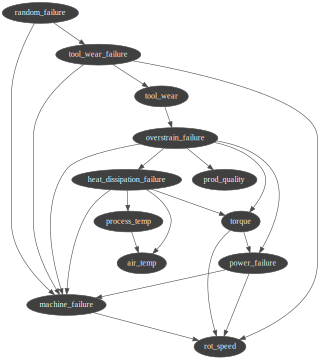

In [157]:
# Bayesian network learned from the data
bn_failure_prediction = failure_prediction.learnBN()
gnb.showBN(bn_failure_prediction)

In [158]:
# Mandatory arcs
failure_prediction.addMandatoryArc("prod_quality","tool_wear") # prod_quality->tool_wear
failure_prediction.addMandatoryArc("tool_wear","tool_wear_failure") # tool_wear->tool_wear_failure
failure_prediction.addMandatoryArc("rot_speed","heat_dissipation_failure") # rot_speed->heat_dissipation_failure
failure_prediction.addMandatoryArc("process_temp","heat_dissipation_failure") # process_temp->heat_dissipation_failure
failure_prediction.addMandatoryArc("air_temp","heat_dissipation_failure") # air_temp->heat_dissipation_failure
failure_prediction.addMandatoryArc("rot_speed","power_failure") # rot_speed->power_failure
failure_prediction.addMandatoryArc("torque","power_failure") # torque->power_failure
failure_prediction.addMandatoryArc("prod_quality","overstrain_failure") # prod_quality->overstrain_failure
failure_prediction.addMandatoryArc("tool_wear","overstrain_failure") # tool_wear->overstrain_failure
failure_prediction.addMandatoryArc("torque","overstrain_failure") # torque->overstrain_failure
failure_prediction.addMandatoryArc("overstrain_failure","machine_failure") # overstrain_failure->machine_failure
failure_prediction.addMandatoryArc("power_failure","machine_failure") # power_failure->machine_failure
failure_prediction.addMandatoryArc("random_failure","machine_failure") # random_failure->machine_failure
failure_prediction.addMandatoryArc("tool_wear_failure","machine_failure") # tool_wear_failure->machine_failure
failure_prediction.addMandatoryArc("heat_dissipation_failure","machine_failure") # heat_dissipation_failure->machine_failure
#gnb.showBN(bn_failure_prediction)

(pyagrum.BNLearner@0x27e26a30) Filename                  : /tmp/tmphl30pddg.csv
Size                      : (10000,12)
Variables                 : prod_quality[3], air_temp[5], process_temp[5], rot_speed[5], torque[5], tool_wear[5], machine_failure[2], tool_wear_failure[2], heat_dissipation_failure[2], power_failure[2], overstrain_failure[2], random_failure[2]
Induced types             : True
Missing values            : False
Algorithm                 : Local Search with Tabu List
Tabu list size            : 2
Score                     : BDeu
Prior                     : -
Constraint Mandatory Arcs : {torque->power_failure, tool_wear->tool_wear_failure, prod_quality->tool_wear, overstrain_failure->machine_failure, torque->overstrain_failure, prod_quality->overstrain_failure, air_temp->heat_dissipation_failure, rot_speed->heat_dissipation_failure, heat_dissipation_failure->machine_failure, rot_speed->power_failure, power_failure->machine_failure, tool_wear->overstrain_failure, process_te

In [159]:
# Forbidden arcs
failure_prediction.addForbiddenArc("air_temp","process_temp")
failure_prediction.addForbiddenArc("process_temp","air_temp")
failure_prediction.addForbiddenArc("rot_speed","torque")
failure_prediction.addForbiddenArc("torque","rot_speed")
failure_prediction.addForbiddenArc("overstrain_failure","rot_speed")
failure_prediction.addForbiddenArc("rot_speed","overstrain_failure")
failure_prediction.addForbiddenArc("heat_dissipation_failure","torque")
failure_prediction.addForbiddenArc("torque","heat_dissipation_failure")
failure_prediction.addForbiddenArc("overstrain_failure","power_failure")
failure_prediction.addForbiddenArc("power_failure","overstrain_failure")
failure_prediction.addForbiddenArc("heat_dissipation_failure","power_failure")
failure_prediction.addForbiddenArc("power_failure","heat_dissipation_failure")
failure_prediction.addForbiddenArc("random_failure","power_failure")
failure_prediction.addForbiddenArc("random_failure","heat_dissipation_failure")
failure_prediction.addForbiddenArc("random_failure","prod_quality")
failure_prediction.addForbiddenArc("prod_quality","random_failure")
failure_prediction.addForbiddenArc("tool_wear_failure","random_failure")
failure_prediction.addForbiddenArc("random_failure","tool_wear_failure")

(pyagrum.BNLearner@0x27e26a30) Filename                  : /tmp/tmphl30pddg.csv
Size                      : (10000,12)
Variables                 : prod_quality[3], air_temp[5], process_temp[5], rot_speed[5], torque[5], tool_wear[5], machine_failure[2], tool_wear_failure[2], heat_dissipation_failure[2], power_failure[2], overstrain_failure[2], random_failure[2]
Induced types             : True
Missing values            : False
Algorithm                 : Local Search with Tabu List
Tabu list size            : 2
Score                     : BDeu
Prior                     : -
Constraint Forbidden Arcs : {heat_dissipation_failure->power_failure, overstrain_failure->power_failure, process_temp->air_temp, tool_wear_failure->random_failure, random_failure->tool_wear_failure, power_failure->heat_dissipation_failure, rot_speed->torque, random_failure->heat_dissipation_failure, random_failure->prod_quality, overstrain_failure->rot_speed, torque->rot_speed, random_failure->power_failure, prod_qual

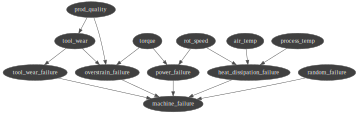

In [160]:
# Network with modified mandatory and forbidden arcs
bn_failure_prediction = failure_prediction.learnBN()
gnb.showBN(bn_failure_prediction)

In [161]:
bn_failure_prediction_learned = gum.BNLearner(df_preprocessed, bn_failure_prediction)
bn_failure_prediction_learned.useSmoothingPrior(weight=1)
learned_failure_prediction = bn_failure_prediction_learned.learnParameters(bn_failure_prediction)

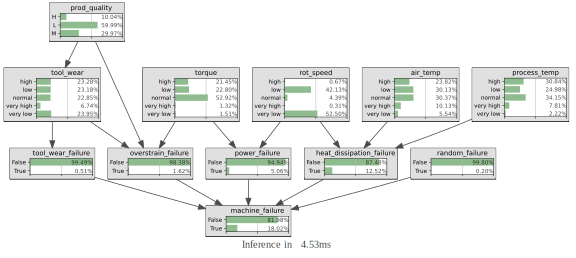

In [162]:
# Show bayesian network with learned probabilities
gnb.showInference(learned_failure_prediction)

In [163]:
from IPython.display import HTML

In [164]:
gnb.sideBySide("<H3>prod_quality</H3>","<H3>tool_wear</H3>",
               learned_failure_prediction.cpt ('prod_quality'),learned_failure_prediction.cpt ('tool_wear'),
               "<H3>torque</H3>","<H3>rot_speed</H3>",
               learned_failure_prediction.cpt ('torque'),learned_failure_prediction.cpt ('rot_speed'),
               "<H3>air_temp</H3>","<H3>process_temp</H3>",
               learned_failure_prediction.cpt ('air_temp'),learned_failure_prediction.cpt ('process_temp'),
               ncols=2)

In [165]:
gnb.sideBySide("<H3>tool_wear_failure</H3>","<H3>overstrain_failure</H3>","<H3>power_failure</H3>",
               learned_failure_prediction.cpt ('tool_wear_failure'),learned_failure_prediction.cpt ('overstrain_failure'),learned_failure_prediction.cpt ('power_failure'),
               "<H3>heat_dissipation_failure</H3>","<H3>random_failure</H3>","<H3>machine_failure</H3>",
               learned_failure_prediction.cpt ('heat_dissipation_failure'),learned_failure_prediction.cpt ('random_failure'),learned_failure_prediction.cpt ('machine_failure'),
               ncols=3)

## Causal inference

In [166]:
cm_learned_failure_prediction = csl.CausalModel(learned_failure_prediction)

In [167]:
def make_infercences(bn, evidence):
  gnb.showInference(bn, evs=evidence)

In [168]:
# Scenario : High stress
# A machine has failed. During troubleshooting the engineer observed that the machine had high rotational speed and torque prior to failure.

# Potential question for the model:\newline
# "Given high rotational speed, high torque and machine failure, what is the probability of overstrain_failure"

high_stress = {
    'rot_speed': 'high',
    'torque': 'high',
    'machine_failure': True
}

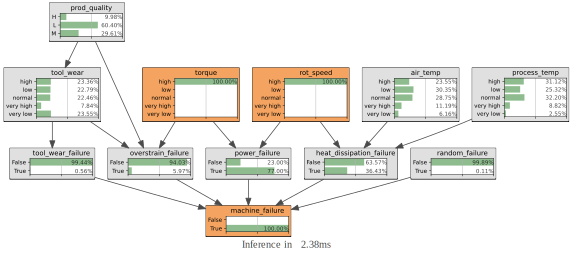

In [169]:
make_infercences(learned_failure_prediction, high_stress)

In [170]:
# Scenario: High temperatures
# A machine has failed. During troubleshooting the engineer observed that both air and process temperatures were very high prior to failure.

# Potential question for the model:
# "Given both air and process temperatures were very high during machine failure, what is the likelihood of heat_dissipation_failure"

high_temperatures = {
    'air_temp': 'very high',
    'process_temp': 'very high',
    'machine_failure': True
}

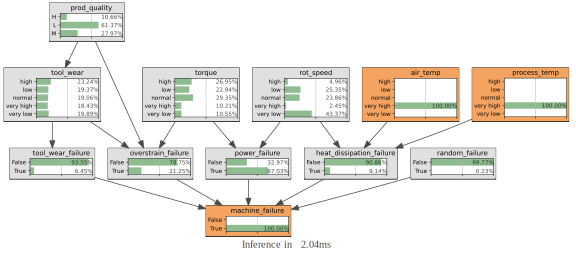

In [171]:
make_infercences(learned_failure_prediction, high_temperatures)

In [172]:
# Scenario: High temperatures revisited
# During the previous investigation, the engineer realized he made a mistake, the process temperature was actually low. He also noticed that the rotational speed was low as well.

# Potential question for the model
# "Given the additional information, what is the likelihood of heat_dissipation_failure"}

high_temperatures_2 = {
    'air_temp': 'very high',
    'process_temp': 'low',
    'rot_speed': 'low',
    'machine_failure': True
}

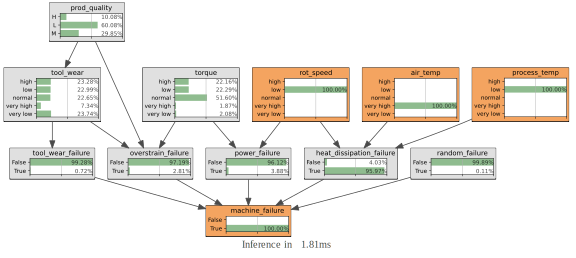

In [173]:
make_infercences(learned_failure_prediction, high_temperatures_2)